In [1]:
from functools import partial
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.scipy.integrate as inte

n = 3
inverse_density = 2 / n
# make triangle grid
normal_x_row = jnp.linspace(-1, 1, n)
staggered_x_row = jnp.linspace(-1 + inverse_density / 2, 1 - inverse_density / 2, n - 1)
# normal_y_column = ((jnp.linspace(-1, 1, n) + 1) ** 3) / (8 / 2) - 1
normal_y_column = jnp.linspace(-1, 1, n)

# now make the grid, taking alternating rows of the staggered grid and always the y column
vertices = []
for i, y in enumerate(normal_y_column):
    if i % 2 == 0:
        vertices.extend(
            jnp.column_stack((normal_x_row, jnp.ones_like(normal_x_row) * y))
        )
    else:
        vertices.extend(
            jnp.column_stack((staggered_x_row, jnp.ones_like(staggered_x_row) * y))
        )

vertices = jnp.array(vertices)

finished triangulation
made 6000 new splits


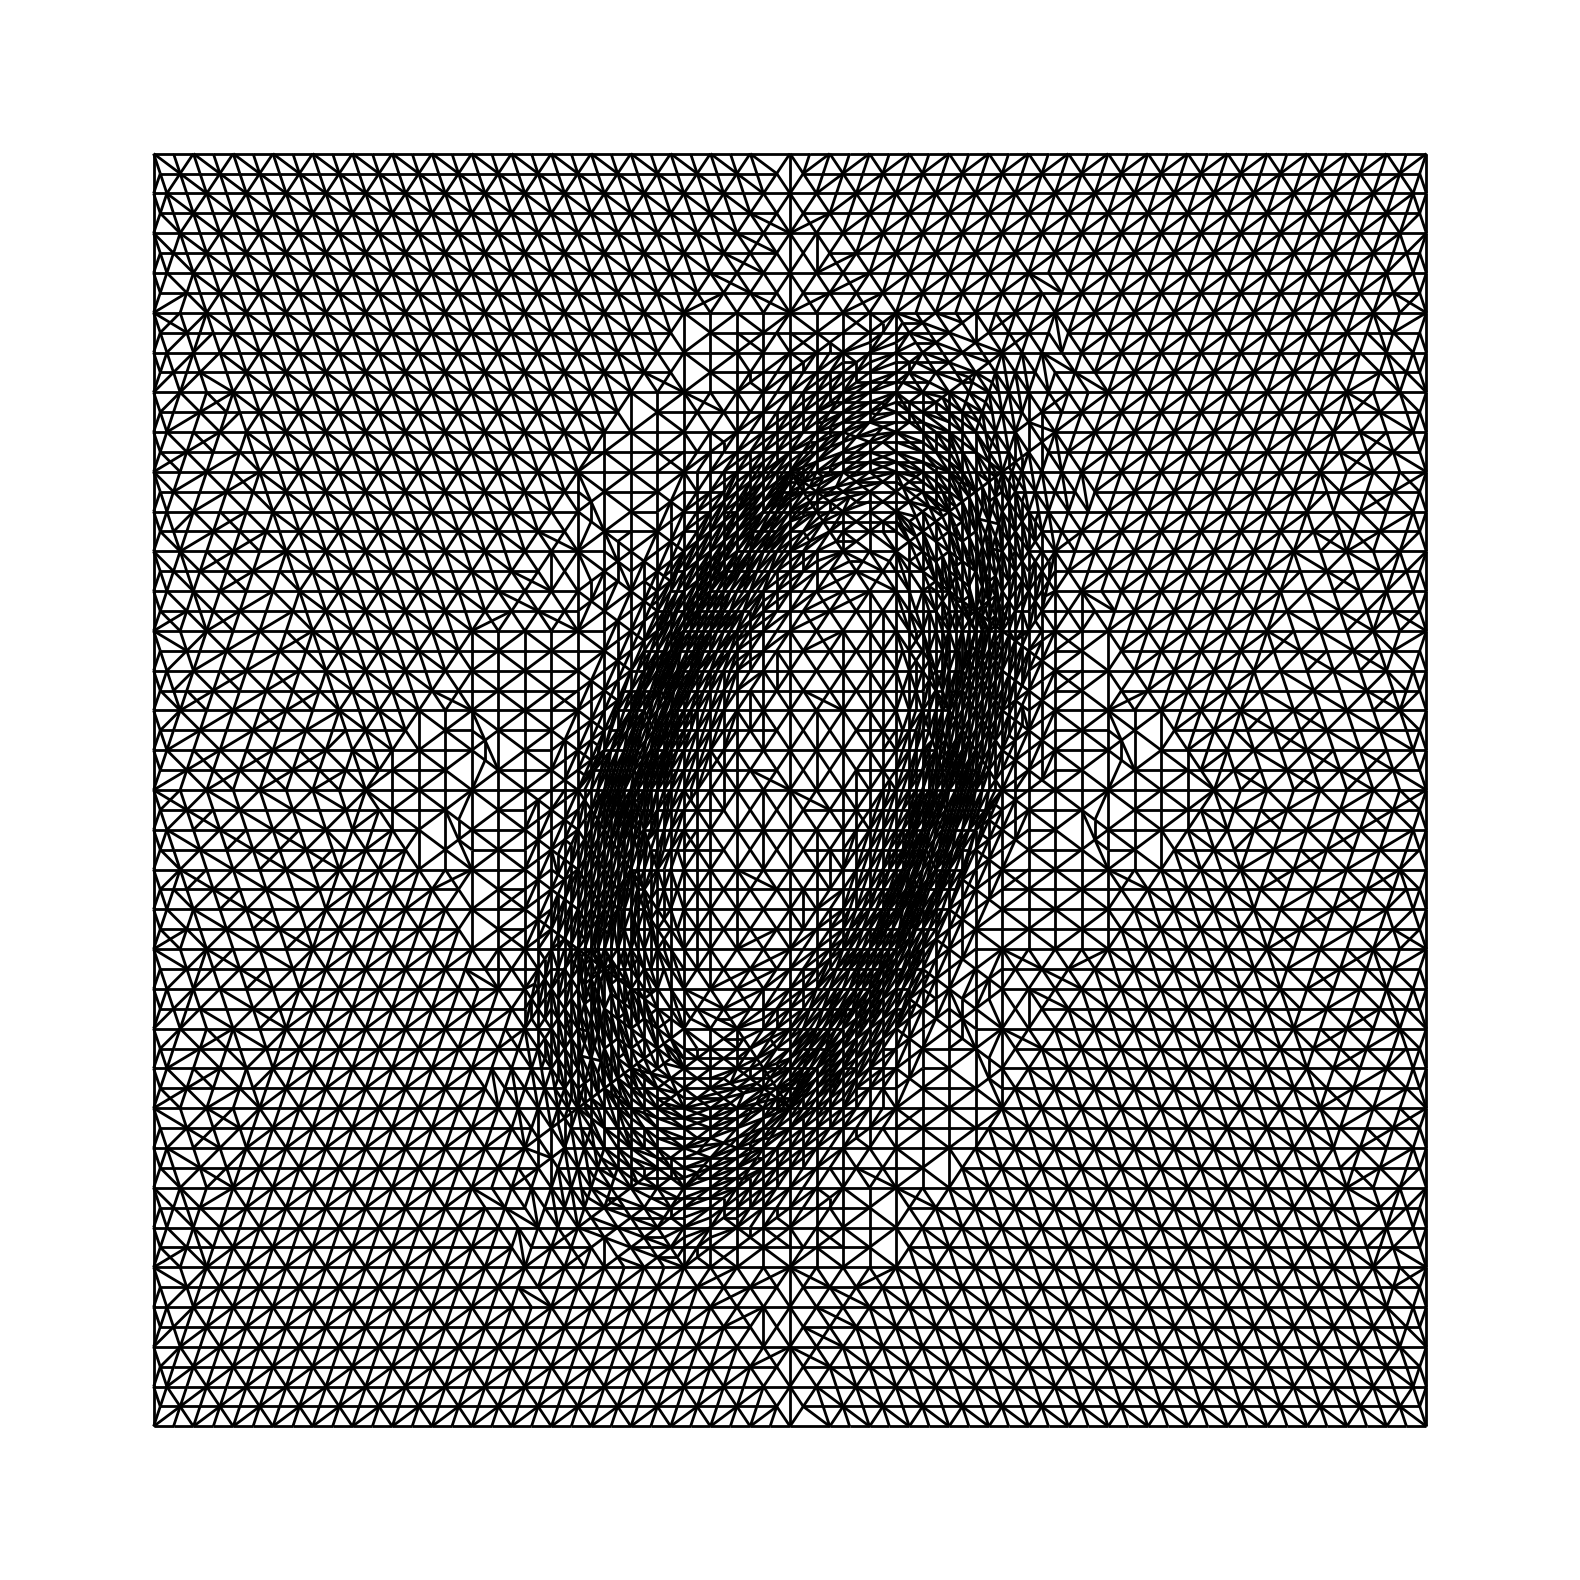

In [2]:
import networkx as nx

graph = nx.Graph()
import matplotlib.tri as tri

import scipy.spatial as sp

triang = sp.Delaunay(vertices)
print("finished triangulation")

# get all edges from the triangulation
edges = set()
for triangle in triang.simplices:
    for i in range(3):
        for j in range(i + 1, 3):
            edges.add((triangle[i], triangle[j]))

edges = list(edges)

from discrete_exterior_calculus import DEC, triangulate, metrics

metric = metrics.projected_bell_metric

mesh = DEC.Mesh(vertices=vertices, faces=triang.simplices, lazy=True)
# mesh = DEC.Mesh.from_obj("../meshes/small-disc.obj", lazy=True)


distance_map = {}
for edge in edges:
    p1 = edge[0]
    p2 = edge[1]

    distance = metrics.measure_distance(
        mesh.vertices[p1, [0, 2]], mesh.vertices[p2, [0, 2]], metric
    )
    distance_map[triangulate.edge(p1, p2)] = distance
    graph.add_edge(p1, p2, weight=distance)

pos = {i: point[[0, 2]] for i, point in enumerate(mesh.vertices)}

# new_faces_and_lengths, new_vertices = triangulate.triangulate_mesh_with_edge_distances(
#     mesh, distance_map
# )
new_faces_and_lengths, new_vertices = triangulate.add_distances_to_mesh_with_metric(
    mesh, metric, max_subdivs=6000
)
new_graph = nx.Graph()
added = set()
for (a, b, c), (A, B, C) in new_faces_and_lengths.items():
    for i, j, dist in [(a, b, C), (b, c, A), (c, a, B)]:
        if (i, j) in added:
            continue
        added.add((i, j))
        new_graph.add_edge(i, j, weight=dist)

new_pos = {i: point for i, point in enumerate(vertices)}

new_mesh = DEC.Mesh(
    vertices=new_vertices, faces=list(new_faces_and_lengths.keys()), lazy=False
)


def draw_graph_with_edge_weights(ax, graph, position):
    ax.set_aspect("equal")
    nx.draw(graph, pos=position, with_labels=False, node_size=0, ax=ax)
    # edge_labels = {
    #     key: str(value)[:4]
    #     for key, value in nx.get_edge_attributes(graph, "weight").items()
    # }
    # nx.draw_networkx_edge_labels(
    #     graph, position, edge_labels=edge_labels, ax=ax, font_size=8
    # )


fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=200)
# draw_graph_with_edge_weights(ax, graph, mesh.vertices[:, [0, 2]])

draw_graph_with_edge_weights(ax, new_graph, new_vertices)
# fig.savefig(
#     "../markdown/latex/images/bell_refined_from_disc.png",
#     dpi=200,
#     transparent=True,
#     bbox_inches="tight",
#     pad_inches=0,
# )
plt.show();

In [3]:
draw_graph_with_edge_weights(ax, new_graph, new_vertices)
# fig.savefig(
#    "../markdown/latex/images/bell_very_refined.png",
#    dpi=200,
#    transparent=True,
#    bbox_inches="tight",
#    pad_inches=0,
# )
plt.show();

In [4]:
# original_faces_and_lengths, vertices = triangulate.add_distances_to_mesh_with_metric(
#     mesh, metric, max_subdivs=0
# )

# embedded_vertices = jnp.array([metrics.embed_to_bell(vertex) for vertex in vertices])
# embedded_vertices = jnp.stack(
#     (embedded_vertices[:, 0], embedded_vertices[:, 2], embedded_vertices[:, 1]), axis=0
# ).T

# mesh = DEC.Mesh(
#     vertices=embedded_vertices, faces=list(original_faces_and_lengths.keys()), lazy=True
# )

# mesh.dump_to_JSON(
#     "bell_initial.json",
#     {"Y": embedded_vertices[:, 1]},
#     folder="../produced_solutions",
# )

In [5]:
# embedded_vertices = jnp.array(
#     [metrics.embed_to_bell(new_vertex) for new_vertex in new_vertices]
# )
# embedded_vertices = jnp.stack(
#     (-embedded_vertices[:, 0], embedded_vertices[:, 2], embedded_vertices[:, 1]), axis=0
# ).T


# new_mesh = DEC.Mesh(
#     vertices=embedded_vertices, faces=list(new_faces_and_lengths.keys()), lazy=True
# )

# new_mesh.dump_to_JSON(
#     "bell_triangulated.json",
#     {"Y": embedded_vertices[:, 1]},
#     folder="../produced_solutions",
# )

In [6]:
# import networkx as nx

# graph = nx.Graph()
# import matplotlib.tri as tri

# import scipy.spatial as sp

# triang = sp.Delaunay(vertices)
# print("finished triangulation")

# # get all edges from the triangulation
# edges = set()
# for triangle in triang.simplices:
#     for i in range(3):
#         for j in range(i + 1, 3):
#             edges.add((triangle[i], triangle[j]))

# edges = list(edges)

# from discrete_exterior_calculus import DEC, triangulate

# mesh = DEC.Mesh(vertices=vertices, faces=triang.simplices, lazy=True)


# distance_map = {}
# for edge in edges:
#     p1 = edge[0]
#     p2 = edge[1]

#     distance = metrics.measure_distance(vertices[p1], vertices[p2])
#     distance_map[triangulate.edge(p1, p2)] = distance
#     graph.add_edge(p1, p2, weight=distance)

# pos = {i: point for i, point in enumerate(vertices)}

# new_faces_and_lengths, new_vertices = triangulate.triangulate_mesh_with_edge_distances(
#     mesh, distance_map
# )
# print("finished subvidision")

# new_graph = nx.Graph()
# added = set()
# for (a, b, c), (A, B, C) in new_faces_and_lengths.items():
#     for i, j, dist in [(a, b, C), (b, c, A), (c, a, B)]:
#         if (i, j) in added:
#             continue
#         added.add((i, j))
#         # ordered = triangulate.edge(a,b)
#         new_graph.add_edge(i, j, weight=dist)

# new_pos = {i: point for i, point in enumerate(vertices)}

# new_mesh = DEC.Mesh(
#     vertices=new_vertices, faces=list(new_faces_and_lengths.keys()), lazy=True
# )


# def draw_graph_with_edge_weights(ax, graph, position):
#     ax.set_aspect("equal")
#     nx.draw(graph, pos=position, with_labels=False, node_size=0, ax=ax)
#     edge_labels = {
#         key: str(value)[:4]
#         for key, value in nx.get_edge_attributes(graph, "weight").items()
#     }
#     nx.draw_networkx_edge_labels(
#         graph, position, edge_labels=edge_labels, ax=ax, font_size=8
#     )


# fig, ax = plt.subplots(1, 3, figsize=(40, 40), dpi=200)

# draw_graph_with_edge_weights(ax[0], graph, vertices)
# draw_graph_with_edge_weights(ax[1], new_graph, new_vertices)
# draw_graph_with_edge_weights(ax[2], new_graph, new_vertices * [0.5, 1.0])


# plt.show();

202
finished dijkstra


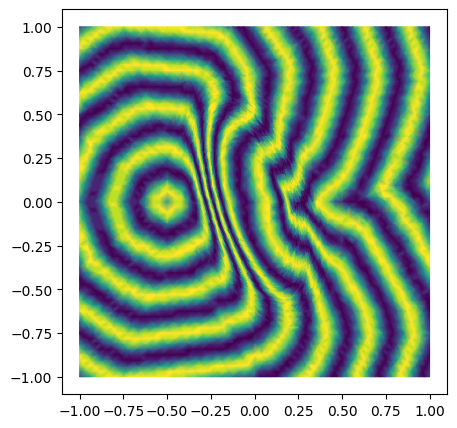

In [11]:
from discrete_exterior_calculus import dijkstra

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)


closest = jnp.argmin(jnp.linalg.norm(new_vertices - jnp.array([-0.5, 0]), axis=1))
print(closest)


def show_wave_propagation(start_pos, graph, vertices, simplices, ax):
    ax.set_aspect("equal")
    distances = dijkstra.dijkstra(graph, start_pos)
    print("finished dijkstra")
    distances = jnp.sin(distances * jnp.pi * 8)
    distances = (distances * 0.5 - 0.5).round(1)

    ax.tripcolor(
        vertices[:, 0], -vertices[:, 1], simplices, distances, shading="gouraud"
    )


# show_wave_propagation(0, graph, triang.simplices, ax[0])
show_wave_propagation(
    int(closest),
    new_graph,
    new_vertices,
    list(new_faces_and_lengths.keys()),
    ax,
)
fig.savefig(
    "../markdown/latex/images/bell_wave_distances.png",
    dpi=200,
    transparent=True,
    bbox_inches="tight",
    pad_inches=0.01,
)

In [8]:
1 / 0
from discrete_exterior_calculus import hyperbolic_laplacian as hl

print(new_faces_and_lengths)
packed_faces = jnp.array(
    [[a, b, c, A, B, C] for (a, b, c), (A, B, C) in new_faces_and_lengths.items()]
)


laplacian = -hl.compute_neg_laplacian(new_mesh, packed_faces)

ZeroDivisionError: division by zero

In [ ]:
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController

mesh_name = f"wave_bell_space.json"

n = len(new_vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    u = y[:n]
    v = y[n:]
    # Compute derivatives
    du_dt = v
    # dv_dt = jnp.tanh(laplace_matrix @ u)
    dv_dt = -laplacian @ u
    # Combine derivatives
    return jnp.concatenate([du_dt, dv_dt])


# Define the ODE term
term = ODETerm(vector_field)

# Solver settings
solver = Dopri5()  # Runge-Kutta method
saveat = SaveAt(ts=jnp.linspace(0, 10, 100))  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-6, atol=1e-6)

initial_cond = jnp.exp(
    -25
    * (jnp.linalg.norm(new_vertices - jnp.array(new_vertices[closest]), axis=1) ** 2)
)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
v0 = jnp.zeros(n)  # Initial condition for v (e.g., zero velocity)
v0 = -laplacian @ initial_cond * 0

y0 = jnp.concatenate([initial_cond, v0])  # Combine u0 and v0 into a single state vector

# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=10,
    dt0=0.1,
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=20000,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

# Visualization (optional)
# import matplotlib.pyplot as plt


# Save the solution to a file
new_mesh.dump_to_JSON(
    mesh_name,
    {
        "initial_cond": initial_cond,
        "initial_velocity": v0,
        "wave": {
            "data": diffrax_sol,
            "start": 0,
            "end": 10,
        },
    },
    folder="../produced_solutions",
)


XlaRuntimeError: INTERNAL: Generated function failed: CpuCallback error: Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 197, in _run_module_as_main
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/runpy.py", line 87, in _run_code
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/events.py", line 80, in _run
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
  File "/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_44653/2183609506.py", line 43, in <module>
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/equinox/_jit.py", line 275, in __call__
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/equinox/_module.py", line 1096, in __call__
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/equinox/_jit.py", line 244, in _call
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/pjit.py", line 327, in cache_miss
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/pjit.py", line 185, in _python_pjit_helper
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/core.py", line 2834, in bind
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/core.py", line 420, in bind_with_trace
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/core.py", line 921, in process_primitive
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/pjit.py", line 1635, in _pjit_call_impl
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/pjit.py", line 1614, in call_impl_cache_miss
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/pjit.py", line 1568, in _pjit_call_impl_python
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/profiler.py", line 335, in wrapper
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/interpreters/pxla.py", line 1244, in __call__
  File "/Users/theoruterwurtzen/Library/Python/3.9/lib/python/site-packages/jax/_src/interpreters/mlir.py", line 2476, in _wrapped_callback
KeyboardInterrupt: 